In [24]:
import pandas as pd
import cv2
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib
import tensorflow as tf
# import tensorflow.compat.v1 as tf
from tensorflow import keras
import numpy as np
from keras.preprocessing.sequence import pad_sequences
import os
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from collections import OrderedDict
# from tensorflow.python.ops import math_ops
import tensorflow.keras.backend as kb
from load_data import Files_Load, Boxes, test_split_norm_abnorm, norm_train_max_min

from sklearn.cluster import KMeans


In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  2


In [3]:
# tf.test.is_gpu_available()

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5500)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

2 Physical GPUs, 2 Logical GPUs


In [5]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  2


# Load Data

In [6]:
frames = 20
startvid=0
endvid=1

train_file = "/home/akanu/Dataset/Anomaly/Avenue_Dataset/bounding_box_tlbr/Txt_Data/Train_Box/"
test_file = "/home/akanu/Dataset/Anomaly/Avenue_Dataset/bounding_box_tlbr/Txt_Data/Test_Box/"

loc_files_train, loc_files_test, box_train_txt, box_test_txt = Files_Load(train_file, test_file)

traindict = Boxes(loc_files_train, box_train_txt, frames, pad ='pre')
testdict = Boxes(loc_files_test[startvid:endvid], box_test_txt[startvid:endvid], frames, pad ='pre')
abnormal_dict, normal_dict = test_split_norm_abnorm(testdict)

# Normilize data
max1 = traindict['x_ppl_box'].max()
min1 = traindict['x_ppl_box'].min()
xx,yy = norm_train_max_min(data_dict = traindict, max1=max1,min1=min1)
xx_norm,yy_norm = norm_train_max_min(data_dict = normal_dict, max1=max1,min1=min1)
xx_abnorm,yy_abnorm = norm_train_max_min(data_dict = abnormal_dict, max1=max1,min1=min1)





In [7]:
frames = 20
startvid=0
endvid=1

train_file = "/home/akanu/Dataset/Anomaly/Avenue_Dataset/bounding_box_xywh/Txt_Data/Train_Box/"
test_file = "/home/akanu/Dataset/Anomaly/Avenue_Dataset/bounding_box_xywh/Txt_Data/Test_Box/"

loc_files_train, loc_files_test, box_train_txt, box_test_txt = Files_Load(train_file, test_file)

traindict1 = Boxes(loc_files_train, box_train_txt, frames, pad ='pre')
testdict1 = Boxes(loc_files_test[startvid:endvid], box_test_txt[startvid:endvid], frames, pad ='pre')
abnormal_dict1, normal_dict1 = test_split_norm_abnorm(testdict)

# Normilize data
max11 = traindict1['x_ppl_box'].max()
min11 = traindict1['x_ppl_box'].min()
xx1,yy1 = norm_train_max_min(data_dict = traindict1, max1=max11,min1=min11)
xx_norm1,yy_norm1 = norm_train_max_min(data_dict = normal_dict1, max1=max11,min1=min11)
xx_abnorm1,yy_abnorm1 = norm_train_max_min(data_dict = abnormal_dict1, max1=max11,min1=min11)

In [11]:
BUFFER_SIZE = 10000
BATCH_SIZE = 32
xx_train, xx_val,yy_train,yy_val = train_test_split(xx,yy, test_size = 0.1)
train_univariate = tf.data.Dataset.from_tensor_slices((xx_train,yy_train))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_univariate = tf.data.Dataset.from_tensor_slices((xx_val,yy_val))
val_univariate = val_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Metrics

In [12]:
def bb_intersection_over_union(y, x):
    xA = kb.max((x[:,0:1],y[:,0:1]), axis=0,keepdims=True)
    yA = kb.max((x[:,1:2],y[:,1:2]), axis=0,keepdims=True)
    xB = kb.min((x[:,2:3],y[:,2:3]), axis=0,keepdims=True)
    yB = kb.min((x[:,3:4],y[:,3:4]), axis=0,keepdims=True)

    interArea1 = kb.max((kb.zeros_like(xB), (xB-xA +1) ), axis=0, keepdims=True)
    interArea2 = kb.max((kb.zeros_like(xB), (yB-yA +1) ), axis=0, keepdims=True)
    interArea = interArea1*interArea2
    boxAArea = (x[:,2:3] - x[:,0:1] + 1) * (x[:,3:4] - x[:,1:2] + 1)
    boxBArea = (y[:,2:3] - y[:,0:1] + 1) * (y[:,3:4] - y[:,1:2] + 1)

    iou = interArea / (boxAArea + boxBArea - interArea)
    iou_mean = -kb.mean(iou)
    return iou_mean





















# LSTM 20 Frames

In [11]:
with tf.device('/device:GPU:1'):
    lstm_20 = keras.Sequential()
    lstm_20.add(keras.layers.InputLayer(input_shape=xx.shape[-2:]))
    lstm_20.add(keras.layers.LSTM(4,return_sequences =True ))
    lstm_20.add(keras.layers.LSTM(3,return_sequences =True ))
    lstm_20.add(keras.layers.LSTM(6,return_sequences =True ))
    lstm_20.add(keras.layers.LSTM(4,return_sequences =True ))
    lstm_20.add(keras.layers.LSTM(4,return_sequences =True ))
    lstm_20.add(keras.layers.LSTM(4) )
    lstm_20.add(keras.layers.Dense(4) )
    opt = tf.keras.optimizers.Adam(learning_rate=8.726e-06)
    checkpoint_cb = keras.callbacks.ModelCheckpoint("tlbr_20_5_arch.h5", 
                                                       save_best_only = True)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.005, patience=5)
    lstm_20.compile(optimizer=opt, loss=bb_intersection_over_union, metrics='mse')
    
    lstm_20_history_1= lstm_20.fit(train_univariate,
                               validation_data = val_univariate,
                               epochs=100, 
                               callbacks = [early_stopping, checkpoint_cb])

Epoch 1/100
3902/3902 [==============================] - 89s 23ms/step - loss: -0.3478 - mse: 0.1102 - val_loss: -0.4653 - val_mse: 0.0542
Epoch 2/100
3902/3902 [==============================] - 88s 22ms/step - loss: -0.5621 - mse: 0.0323 - val_loss: -0.6750 - val_mse: 0.0174
Epoch 3/100
3902/3902 [==============================] - 88s 22ms/step - loss: -0.7764 - mse: 0.0095 - val_loss: -0.8531 - val_mse: 0.0037
Epoch 4/100
3902/3902 [==============================] - 88s 22ms/step - loss: -0.8827 - mse: 0.0023 - val_loss: -0.9049 - val_mse: 0.0014
Epoch 5/100
3902/3902 [==============================] - 88s 22ms/step - loss: -0.9216 - mse: 9.8796e-04 - val_loss: -0.9343 - val_mse: 7.8346e-04
Epoch 6/100
3902/3902 [==============================] - 88s 22ms/step - loss: -0.9381 - mse: 7.2237e-04 - val_loss: -0.9402 - val_mse: 7.0497e-04
Epoch 7/100
3902/3902 [==============================] - 88s 22ms/step - loss: -0.9418 - mse: 6.7206e-04 - val_loss: -0.9431 - val_mse: 6.6793e-04
Epo

In [12]:
lstm_20.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 4)             144       
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 3)             96        
_________________________________________________________________
lstm_2 (LSTM)                (None, 20, 6)             240       
_________________________________________________________________
lstm_3 (LSTM)                (None, 20, 4)             176       
_________________________________________________________________
lstm_4 (LSTM)                (None, 20, 4)             144       
_________________________________________________________________
lstm_5 (LSTM)                (None, 4)                 144       
_________________________________________________________________
dense (Dense)                (None, 4)                 2

Text(0.5, 1.0, 'LSTM, 20 Frames')

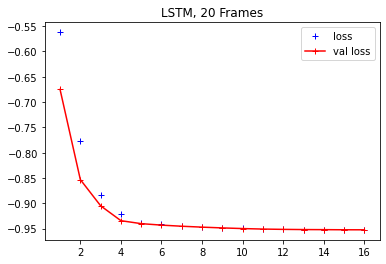

In [14]:
i =1
j=17
plt.plot(np.arange(i,j), lstm_20_history_1.history['loss'][i:j],'b+', label='loss')
plt.plot(np.arange(i,j), lstm_20_history_1.history['val_loss'][i:j],'r-+', label='val loss')

plt.legend()
plt.title('LSTM, 20 Frames')

# Results creation

In [13]:
def visual_ouput(model=None,max1 = None,min1=None, vid=None,pic_loc =None, output_dict=None,tlbr = True):
    # Right now this only works for one video at a time
    
    xx,yy = norm_train_max_min(data_dict = output_dict, max1 = max1,min1 =min1)
    size = len(output_dict['frame_ppl_id'])
    
    #sort index by frames
    frame = []
    for i in range(0,size):
        #sort index by frames
        frame.append(output_dict['frame_ppl_id'][i,-1,0])
    
    frame = np.array(frame)
    sort_index = frame.argsort()
    #Sorted from first to last frame
    xx_scal, yy_scal = xx[sort_index], yy[sort_index]
    vid_file = output_dict['video_file'][sort_index] # not really needed if using one video
    frame_ppl = output_dict['frame_ppl_id'][sort_index]
    y_true = output_dict['y_ppl_box'][sort_index] # not normailized
    
    # Note that predicted outout is already sorted
    y_pred_scal = model.predict(xx_scal)
    y_pred = norm_train_max_min(data=y_pred_scal, max1 = max1,min1 =min1,undo_norm=True)
    

    stop = frame[sort_index][-1] + 1
    next_frame_index,j = 0,0
    
    #  Start Video
    loc_videos ="/home/akanu/Dataset/Anomaly/Avenue_Dataset/testing_videos/{:02}.avi".format(vid)
    video_capture = cv2.VideoCapture(loc_videos)

    if not tlbr:
        pass
        # Need to call a fuction that changes to tlbw so I can plot correctly
    for i in range(0,stop):
        ret, frame = video_capture.read()
        if i == frame_ppl[j,-1,0]: #finds the frame
            while i == frame_ppl[j,-1,0]:
                y_fr_act = y_true[j]
                y_fr_pred = y_pred[j]
                id1 = frame_ppl[j,-1,1]
#                 print("{}  ,{}".format(y_fr_act.shape, y_fr_pred.shape))

                gt_frame = frame.copy()
                pred_frame = frame.copy()
                both_frame = frame.copy()

    
                # Ground Truth
                cv2.rectangle(gt_frame, (int(y_fr_act[0]), int(y_fr_act[1])), (int(y_fr_act[2]), int(y_fr_act[3])),(0,255,0), 2)
#                 cv2.putText(gt_frame, str(frame_ppl[j,-1,1]),(int(y_fr_act[0]), int(y_fr_act[1])),0, 5e-3 * 200, (255,255,0),2)
                
                # Predicted
                cv2.rectangle(pred_frame, (int(y_fr_pred[0]), int(y_fr_pred[1])), (int(y_fr_pred[2]), int(y_fr_pred[3])),(0,255,255), 2)
#                 cv2.putText(pred_frame, str(frame_ppl[j,-1,1]),(int(y_fr_pred[2]), int(y_fr_pred[3])),0, 5e-3 * 200, (255,255,0),2)
                
                # Combined frame
                cv2.rectangle(both_frame, (int(y_fr_act[0]), int(y_fr_act[1])), (int(y_fr_act[2]), int(y_fr_act[3])),(0,255,0), 2)
#                 cv2.putText(both_frame, str(frame_ppl[j,-1,1]),(int(y_fr_act[0]), int(y_fr_act[1])),0, 5e-3 * 200, (255,255,0),2)
                cv2.rectangle(both_frame, (int(y_fr_pred[0]), int(y_fr_pred[1])), (int(y_fr_pred[2]), int(y_fr_pred[3])),(0,255,255), 2)
#                 cv2.putText(both_frame, str(frame_ppl[j,-1,1]),(int(y_fr_pred[2]), int(y_fr_pred[3])),0, 5e-3 * 200, (255,255,0),2)
                
                
                cv2.imwrite(pic_loc.format(vid,i,id1) + '_gt.jpg', gt_frame)
                cv2.imwrite(pic_loc.format(vid,i,id1) + '_pred.jpg', pred_frame)
                cv2.imwrite(pic_loc.format(vid,i,id1) + '_both.jpg', both_frame)



                
                next_frame_index +=1
                j = next_frame_index
#                 print('saved')
#                 print(j)
                if j == size:
                    return

In [14]:
# start = time.time()
# pic_loc = '/home/akanu/git/anomalous_pred/resulting_images/tlbr/test_norm/{:02d}_{:02d}_{}'
# visual_ouput(model=lstm_20,max1 = max1,min1=min1, vid=1, pic_loc =pic_loc, output_dict=normal_dict,tlbr = True)
# end = time.time()
# print(end-start)

In [15]:
# pic_loc = '/home/akanu/git/anomalous_pred/resulting_images/tlbr/test_abnorm/{:02d}_{:02d}_{}'
# visual_ouput(model=lstm_20,max1 = max1,min1=min1, vid=1, pic_loc =pic_loc, output_dict=abnorm_dict,tlbr = True)

# Pedestrain

In [16]:
def pedsort(datadict):
    
    ped = {}
    
    # For each pedestrain want to create a new key
    per_id = np.unique(datadict['frame_ppl_id'][:,-1,1])
    for i in per_id:
        ped[str(i)] = {}
        index = np.where(datadict['frame_ppl_id'][:,-1,1] == i)
        # should ensure it sorted by frame
        temp = {}
        for key in datadict.keys():
            temp[key] = datadict[key][index]
            
        ped[str(i)] = temp
    return ped
        
    

In [17]:
def bb_intersection_over_union_np(y, x):
    y = y.astype(float)
    x = x.astype(float)
    xA = np.max((x[:,0:1],y[:,0:1]), axis=0,keepdims=True)
    yA = np.max((x[:,1:2],y[:,1:2]), axis=0,keepdims=True)
    xB = np.min((x[:,2:3],y[:,2:3]), axis=0,keepdims=True)
    yB = np.min((x[:,3:4],y[:,3:4]), axis=0,keepdims=True)

    interArea1 = np.max((np.zeros_like(xB), (xB-xA +1) ), axis=0, keepdims=True)
    interArea2 = np.max((np.zeros_like(xB), (yB-yA +1) ), axis=0, keepdims=True)
    interArea = interArea1*interArea2
    boxAArea = (x[:,2:3] - x[:,0:1] + 1) * (x[:,3:4] - x[:,1:2] + 1)
    boxBArea = (y[:,2:3] - y[:,0:1] + 1) * (y[:,3:4] - y[:,1:2] + 1)

    iou = interArea / (boxAArea + boxBArea - interArea)
#     iou_mean = -np.mean(iou)
    return iou

In [18]:
ped = pedsort(testdict)

In [146]:
norm_train_max_min(data=y, max1=max1, min1=min1 , undo_norm=True)[:10]

array([[ 84.,   0., 308., 370.],
       [ 89.,   0., 320., 370.],
       [ 92.,   0., 328., 366.],
       [ 89.,   1., 333., 367.],
       [ 70.,   8., 316., 368.],
       [ 63.,  11., 315., 369.],
       [ 59.,  15., 314., 367.],
       [ 79.,  12., 336., 365.],
       [ 94.,   9., 355., 363.],
       [117.,   5., 381., 358.]])

In [145]:
ped[j]['y_ppl_box'][:10]

array([[ 84,   0, 308, 370],
       [ 89,   0, 320, 370],
       [ 92,   0, 328, 366],
       [ 89,   1, 333, 367],
       [ 70,   8, 316, 368],
       [ 63,  11, 315, 369],
       [ 59,  15, 314, 367],
       [ 79,  12, 336, 365],
       [ 94,   9, 355, 363],
       [117,   5, 381, 358]])

In [65]:
out1 = model.predict(x)
# out = norm_train_max_min(data=out1, max1 = max1,min1 =min1,undo_norm=True)
# bb_intersection_over_union_np(out, ped[j]['y_ppl_box'])
out = bb_intersection_over_union_np(out1,y)
# out = bb_intersection_over_union_np(out,ped[j]['y_ppl_box'])

Text(0, 0.5, 'IOU')

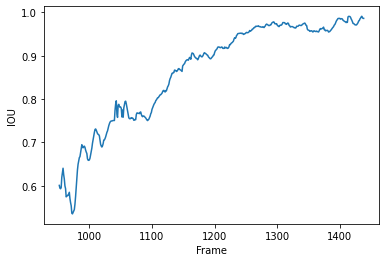

In [153]:
plt.plot(ped[j]['frame_ppl_id'][:,-1,0], np.squeeze(out),'-')
plt.xlabel('Frame')
plt.ylabel('IOU')

In [125]:
out[:10]

array([[[[0.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00],
         [2.34519165e-03],
 

In [47]:
ped[j]['y_ppl_box'][:10]

array([[478, 111, 512, 240],
       [478, 111, 512, 240],
       [478, 111, 512, 240],
       [479, 111, 512, 240],
       [478, 111, 512, 240],
       [478, 111, 512, 240],
       [478, 110, 513, 241],
       [478, 110, 513, 241],
       [479, 110, 513, 241],
       [478, 110, 513, 241]])

In [43]:
out1[:10]

array([[0.5828437 , 0.25028276, 0.61620283, 0.3549063 ],
       [0.58260924, 0.25028917, 0.6159913 , 0.35489607],
       [0.5824663 , 0.2502936 , 0.61585766, 0.35489476],
       [0.5823074 , 0.25029838, 0.61571133, 0.35489047],
       [0.58213866, 0.25030324, 0.6155578 , 0.35488355],
       [0.58197105, 0.25030768, 0.61540544, 0.3548777 ],
       [0.581867  , 0.25031126, 0.61530924, 0.35487458],
       [0.5817988 , 0.2503136 , 0.6152439 , 0.35487577],
       [0.5817316 , 0.2503159 , 0.6151812 , 0.35487488],
       [0.5816796 , 0.2503176 , 0.61513203, 0.35487616]], dtype=float32)

In [42]:
y[:10]

array([[0.5890028 , 0.24697111, 0.62068966, 0.36719478],
       [0.5890028 , 0.24697111, 0.62068966, 0.36719478],
       [0.5890028 , 0.24697111, 0.62068966, 0.36719478],
       [0.58993476, 0.24697111, 0.62068966, 0.36719478],
       [0.5890028 , 0.24697111, 0.62068966, 0.36719478],
       [0.5890028 , 0.24697111, 0.62068966, 0.36719478],
       [0.5890028 , 0.24603914, 0.62162162, 0.36812675],
       [0.5890028 , 0.24603914, 0.62162162, 0.36812675],
       [0.58993476, 0.24603914, 0.62162162, 0.36812675],
       [0.5890028 , 0.24603914, 0.62162162, 0.36812675]])

In [62]:
j='86'
x,y = norm_train_max_min(data_dict=ped[j], max1=max1, min1=min1 )



In [68]:
y[0:1,:]

array([[0.22180801, 0.14352283, 0.4305685 , 0.48835042]])

In [69]:
out1[0:1,:]

array([[0.13351457, 0.24464065, 0.15598539, 0.3532132 ]], dtype=float32)

In [74]:
bb_intersection_over_union_np(y[0:1,:],out1[0:1,:])

array([[[[0.60088828]]]])

In [54]:
bb_intersection_over_union_np(ped[j]['y_ppl_box'][0:1,:],out[0:1,:])

array([[[[0.64524826]]]])

In [147]:
model_l= tf.keras.models.load_model('tlbr_20_5_arch.h5', custom_objects = {'loss':bb_intersection_over_union} , compile=False)

# K means

In [19]:
model = tf.keras.models.load_model('tlbr_20_5_arch.h5', custom_objects = {'loss':bb_intersection_over_union} , compile=False)

In [21]:
xx_test,yy_test= norm_train_max_min(data_dict = testdict, max1=max1,min1=min1)


In [22]:
y_pred_scal = model.predict(xx_test)
y_pred = norm_train_max_min(data=y_pred_scal, max1 = max1,min1 =min1,undo_norm=True)

In [27]:
kmean_scal = KMeans(n_clusters=2)
kmean = KMeans(n_clusters=2)

In [31]:
def tlbr_xywh(data):
    data = data.astype(float)
    data[:,2] = np.abs(data[:,2] - data[:,0] )
    data[:,3] = np.abs(data[:,3] - data[:,1])
    
    data[:,0] = data[:,0] + data[:,2]/2
    data[:,1] = data[:,1] + data[:,3]/2
  
    
    return data

In [30]:
tlbr_xywh(y_pred)

array([[489.28845215, 170.68392944,  35.79431152, 112.26104736],
       [489.04919434, 170.68186951,  35.81896973, 112.24319458],
       [488.90078735, 170.68354797,  35.82891846, 112.23703003],
       ...,
       [248.14785767, 167.50546265,  52.36914062,  94.7557373 ],
       [ 93.65380859, 170.02760315,  34.92657471, 114.79934692],
       [ 94.46871948, 170.04417419,  35.28271484, 114.3921814 ]])

In [33]:
kmean_scal.fit(tlbr_xywh(y_pred_scal)[:,0:2])
kmean.fit(tlbr_xywh(y_pred)[:,0:2])

KMeans(n_clusters=2)

In [34]:
out = kmean_scal.cluster_centers_
out

array([[0.29874876, 0.30335072],
       [0.59389225, 0.3018624 ]])

In [35]:
out1 = kmean.cluster_centers_
out1

array([[483.19178273, 169.89946553],
       [166.46763196, 171.49441585]])

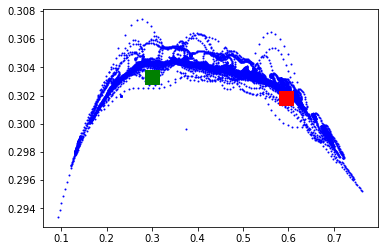

In [40]:
plt.scatter(tlbr_xywh(y_pred_scal)[:,0], tlbr_xywh(y_pred_scal)[:,1],s=1, c='b')
plt.scatter(out[0,0], out[0,1],s=200, c ='g', marker='s')
plt.scatter(out[1,0], out[1,1], s=200, c ='r', marker='s')

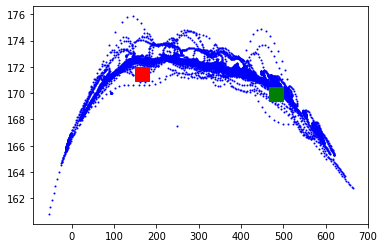

In [41]:
plt.scatter(tlbr_xywh(y_pred)[:,0], tlbr_xywh(y_pred)[:,1],s=1, c='b')
plt.scatter(out1[0,0], out1[0,1],s=200, c ='g', marker='s')
plt.scatter(out1[1,0], out1[1,1], s=200, c ='r', marker='s')

# Using X Difference

In [90]:
j = '12'
out = model.predict(ped[j]['x_ppl_box'])
out = norm_train_max_min(data=out, max1 = max1,min1 =min1,undo_norm=True)
out = tlbr_xywh(out)

In [91]:
out

array([[-178.09767914,  132.25718689,   17.11585999,  118.39840698],
       [-178.09772491,  132.25714874,   17.11582947,  118.39842224],
       [-178.09775543,  132.25711823,   17.11582947,  118.39842224],
       ...,
       [  44.22453308,  159.91265869,   33.93081665,  120.67071533],
       [  44.22681427,  159.91273499,   33.93107605,  120.67056274],
       [  44.22960663,  159.91287994,   33.93138123,  120.67045593]])

In [96]:
xy_diff = []
for i in range(1,len(out)):
    
    xy_diff.append(out[i,:] - out[i-1,:])

xy_diff = np.array(xy_diff)
out =np.sum(np.square(xy_diff[:,0:2]), axis=1)
    

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

Text(0.5, 0, 'Frame')

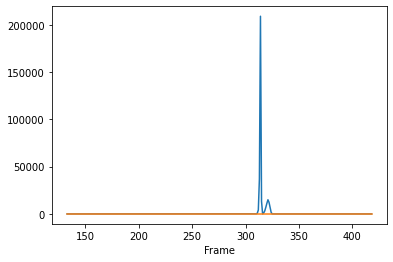

In [95]:
plt.plot(ped[j]['frame_ppl_id'][1:,-1,0], out,'-')
plt.plot(ped[j]['frame_ppl_id'][1:,-1,0],ped[j]['abnormal'][1:]*1000 )
# plt.plot(ped[j]['frame_ppl_id'][1:,-1,0], xy_diff[:,0],'-+')
# plt.plot(ped[j]['frame_ppl_id'][1:,-1,0], xy_diff[:,1],'-0')
plt.xlabel('Frame')

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])